In [2]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from sig_proc import lfca
import numpy as np
import scipy as sp
import cartopy
import cartopy.crs as ccrs
import nclcmaps as ncm
from cartopy.util import add_cyclic_point
from datetime import datetime, timedelta
import pandas as pd
import os
import moviepy.video.io.ImageSequenceClip
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from lowpass import lowpass

In [3]:
from matplotlib.backends import backend_agg

In [4]:
def keep_center_colormap(vmin, vmax, colors, center=0):
    vmin = vmin - center
    vmax = vmax - center
    dv = max(-vmin, vmax) * 2
    N = int(256 * dv / (vmax-vmin))
    RdBu_r = cm.get_cmap(colors, N)
    newcolors = RdBu_r(np.linspace(0, 1, N))
    beg = int((dv / 2 + vmin)*N / dv)
    end = N - int((dv / 2 - vmax)*N / dv)
    newmap = ListedColormap(newcolors[beg:end])
    return newmap

## LFCA

In [5]:
# import surface temperature file
filepath="C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/BEST_1850_2022/temperature_185001-202212_2.00x2.00deg.nc"
data = xr.open_dataset(filepath)
tas_anom =  data['temperature']
tas_clim =  data['climatology']
lat      = data['lat']
lon      = data['lon']

# partition into a monthly, year, lat, lon array
nyr = (2022-1850 + 1)
nmn = 12
nlt = len(lat)
nln = len(lon)
tas_data = np.zeros((nmn,nyr,nlt,nln))
for mn in range(nmn):
    mon = mn
    for yr in range(nyr):
        tas_data[mn,yr,:,:] = tas_anom[mon,:,:]
        mon = mon+12

# because of missing and questionable data, we restrict.
tas_data[:,:,0:15,:] = np.nan
        
# calculate anomalies relative to 1850-1900
tas_data = tas_data+np.expand_dims(tas_clim,1)
tas_anom = tas_data - np.expand_dims(np.nanmean(tas_data[:,0:50,:,:],axis=1),1)
        
# annual mean anomalies 
tas_anom = np.nanmean(tas_anom[:,:,:],axis=0)
tas = np.array(tas_anom).transpose(2,1,0)

C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\4201930275.py:26: RuntimeWarning: Mean of empty slice
  tas_anom = tas_data - np.expand_dims(np.nanmean(tas_data[:,0:50,:,:],axis=1),1)
C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\4201930275.py:29: RuntimeWarning: Mean of empty slice
  tas_anom = np.nanmean(tas_anom[:,:,:],axis=0)


In [6]:
max_miss = 0.15
exclude = []
## how many NANs?
# for each map point:
for lat_ in range(nlt):
    for lon_  in range(nln):
        if np.isnan(tas_anom[:,lat_,lon_]).sum()/len(tas_anom[:,lat_,lon_]) >= max_miss:
            exclude.append((lat_,lon_))

print(len(exclude))

3022


C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\1689565071.py:5: RuntimeWarning: Mean of empty slice
  zonal = np.nanmean(tas_anom, axis = 2)


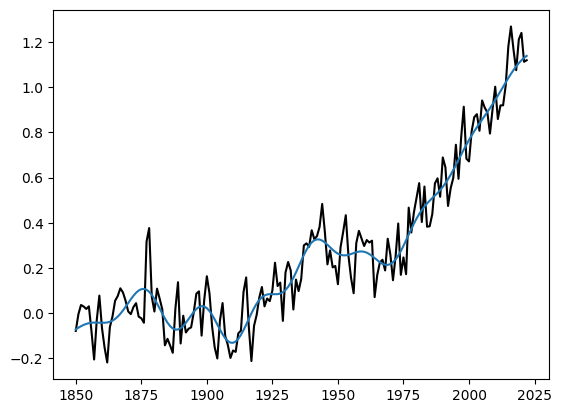

In [7]:
# follow matlab to lowpass filter obs line

## troubleshooting observation line
weights = np.cos(np.deg2rad(np.array(lat)))
zonal = np.nanmean(tas_anom, axis = 2)
gm = np.nansum(zonal*np.expand_dims(weights,0),axis=1)/np.nansum(weights)
plt.plot(range(1850,2023),gm, label='Annual mean temperature anomaly', color="k")

lowpassobs = lowpass(gm, 1/20)  # cutoff freq is 1/yr
plt.plot(range(1850,2023),lowpassobs)
#plt.plot(range(1850,2023),lowpassobs, label='Filtered annual mean temp anomaly', color="blue")


In [7]:
# legacy code to normalize by trace of covariance
variable = np.transpose(tas_anom,(2,1,0)) #tas  # VAR
s = variable.shape
y, x = np.meshgrid(lat,lon)
area = (np.cos(y*np.pi/180.))
area[np.where(np.isnan(np.nanmean(variable,axis=2)))] = np.nan

domain = np.ones(area.shape)

order = 'C'
x = np.transpose(np.reshape(variable,(s[0]*s[1],s[2]),order=order))
area_weights = np.transpose(np.reshape(area,(s[0]*s[1],1),order=order))
domain = np.transpose(np.reshape(domain,(s[0]*s[1],1),order=order))
icol_ret = np.where((area_weights!=0) & (domain!=0))
icol_disc = np.where((area_weights==0) | (domain==0))
x = x[:,icol_ret[1]]
area_weights = area_weights[:,icol_ret[1]]
normvec = np.transpose(area_weights)/np.sum(area_weights)
scale = np.sqrt(normvec)

isn=np.isnan(x)
x[isn]=0

cov_x = np.cov(x)
variable1_scale = np.trace(cov_x)

C:\Users\sydne\AppData\Local\Temp\ipykernel_26384\2277258798.py:6: RuntimeWarning: Mean of empty slice
  area[np.where(np.isnan(np.nanmean(variable,axis=2)))] = np.nan


In [ ]:
# input into LFCA
field  = np.transpose(tas_anom,(2,1,0))/variable1_scale ## VAR
lon_n  = lon

In [ ]:
# more code to get input ready for LFCA
s = field.shape
y, x = np.meshgrid(lat,lon_n)
area = (np.cos(y*np.pi/180.))
area[np.where(np.isnan(np.nanmean(field[:,:,:],axis=2)))] = 0

domain = np.ones(area.shape)

order = 'C'
x = np.transpose(np.reshape(field,(s[0]*s[1],s[2]),order=order))
area_weights = np.transpose(np.reshape(area,(s[0]*s[1],1),order=order))
domain = np.transpose(np.reshape(domain,(s[0]*s[1],1),order=order))
icol_ret = np.where((area_weights!=0) & (domain!=0))
icol_disc = np.where((area_weights==0) | (domain==0))
x = x[:,icol_ret[1]]
area_weights = area_weights[:,icol_ret[1]]
normvec = np.transpose(area_weights)/np.sum(area_weights)
scale = np.sqrt(normvec)

isn=np.isnan(x)
x[isn]=0

In [ ]:
# two parameters for LFCA
cutoff = 20
truncation = 20

lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs = lfca(x, cutoff, truncation, scale)

In [ ]:
nins = np.size(icol_disc[1])
nrows = lfps.shape[0]
lfps_aug = np.zeros((nrows,lfps.shape[1]+nins))
lfps_aug[:] = np.nan
lfps_aug[:,icol_ret[1]] = lfps
nrows = eofs.shape[0]
eofs_aug = np.zeros((nrows,eofs.shape[1]+nins))
eofs_aug[:] = np.nan
eofs_aug[:,icol_ret[1]] = eofs

nlat = len(lat)
nlon = len(lon_n)
lfps_all=np.reshape(lfps_aug,(truncation,nlon,nlat))
lfps_all[np.where(np.abs(lfps_all)>1e5)] = np.nan

lfcs_all = lfcs.T

lfps_f = lfps_all
lfps_f = np.array(lfps_f).transpose(0,2,1)*variable1_scale
lfcs_f = lfcs_all
pvar_f = pvar_slow
r_f    = r

In [ ]:
# Save data in netCDF file
from netCDF4 import Dataset 
from numpy import dtype
seasonal=''
ncout = Dataset('netCDF_files/BEST_LFCA_temperature_'+str(truncation)+'_Eofs_'+str(cutoff)+'yr_cutoff_03-31-2024'+seasonal+'.nc', 'w', format='NETCDF4')

ncout.createDimension('num' , truncation)
ncout.createDimension('year', nyr)
ncout.createDimension('lat' , nlt)
ncout.createDimension('lon' , nln)

vout1 = ncout.createVariable('lat', dtype('double').char,('lat'))
vout1.long_name = ''
vout1.units = ''

vout2 = ncout.createVariable('lon', dtype('double').char,('lon'))
vout2.long_name = ''
vout2.units = ''

vout3 = ncout.createVariable('lfcs_f', dtype('double').char,('num','year'))
vout3.long_name = ''
vout3.units = ''

vout4 = ncout.createVariable('lfps_f', dtype('double').char,('num','lat','lon'))
vout4.long_name = ''
vout4.units = ''

vout5 = ncout.createVariable('pvar_f', dtype('double').char,('num'))
vout5.long_name = ''
vout5.units = ''

vout6 = ncout.createVariable('r_f', dtype('double').char,('num'))
vout6.long_name = ''
vout6.units = ''

vout1[:] = lat 
vout2[:] = lon 
vout3[:,:] = lfcs_f.real
vout4[:,:,:] = lfps_f[:,:,:].real 
vout5[:] = pvar_f.real
vout6[:] = r_f.real

ncout.close()

### pull spatial trend from obs

In [8]:
## open+process LFCA file
num_eofs = 20
cutoff = 20
seasonal = ''

#filepath='netCDF_files/BEST_LFCA_temperature_'+str(num_eofs)+'_Eofs_'+str(cutoff)+'yr_cutoff_03-31-2024.nc'  
filepath='C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/netCDF_files/BEST_LFCA_temperature_'+str(num_eofs)+'_Eofs_'+str(cutoff)+'yr_cutoff_03-31-2024_20_20.nc'  

lfca_data = xr.open_dataset(filepath)
lfps =  lfca_data['lfps_f']
lfcs =  lfca_data['lfcs_f']
lat  = lfca_data['lat']
lon  = lfca_data['lon']

## VIDEO

In [9]:
## spatial pattern given by retained LFCs
lfc_ret0 = lfca_data.lfcs_f[0,:]
lfc_ret1 = lfca_data.lfcs_f[1,:]
lfc_ret0 = lowpass(lfc_ret0,1/20)
lfc_ret1 = lowpass(lfc_ret1,1/20)

lfca_spatial_1 = np.expand_dims(np.expand_dims(lfc_ret0,1),2)*np.expand_dims(lfca_data.lfps_f[0,:],0)
lfca_spatial_2 = np.expand_dims(np.expand_dims(lfc_ret1,1),2)*np.expand_dims(lfca_data.lfps_f[1,:],0)

lfca_spatial = lfca_spatial_1 + lfca_spatial_2
weights = np.cos(np.deg2rad(np.array(lat)))

In [10]:
lfca_data

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 181, num: 20, year: 173)
Coordinates:
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float64 0.0 1.989 3.978 5.967 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: num, year
Data variables:
    lfcs_f   (num, year) float64 ...
    lfps_f   (num, lat, lon) float64 ...
    pvar_f   (num) float64 ...
    r_f      (num) float64 ...

C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\1830439444.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  RdBu_r = cm.get_cmap(colors, N)
C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\156170566.py:47: RuntimeWarning: Mean of empty slice
  zonal = np.nanmean(tas_anom, axis = 2)
C:\Users\sydne\AppData\Local\Temp\ipykernel_28316\156170566.py:51: RuntimeWarning: Mean of empty slice
  zonal_lfca = np.nanmean(np.array(lfca_spatial), axis = 2)


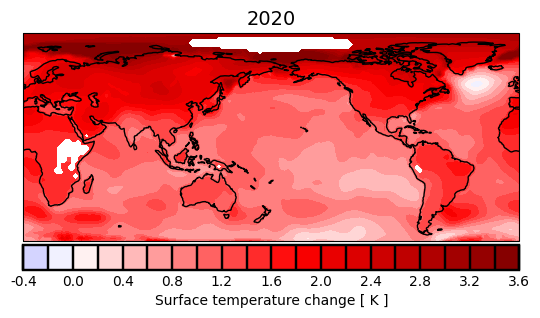

In [17]:
## export images for video (v1)
for yr in lfca_data.year.values[170:171]:
    
    #fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(4, 5, figure=fig)

    # subplot 1
    ax1 = fig.add_subplot(gs[:-1,:])

    for lat_,lon_ in exclude:
        lfca_spatial[yr,lat_,lon_] = None
    

    cmap = 'seismic'

    cb_min = -0.4
    cb_max = +3.6

    newmap = keep_center_colormap(cb_min, cb_max, cmap, center=0)

    data = lfca_spatial[yr,:,:]
    data[data<cb_min]=cb_min
    data[data>cb_max]=cb_max

    ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    cf = ax1.contourf(lfca_data.lon, lfca_data.lat, lfca_spatial[yr,:,:], np.arange(cb_min,cb_max+0.2,0.2),cmap=newmap, transform=ccrs.PlateCarree())

    plt.title(yr+1850,fontsize=14)

    kwargs = {'format': '%.1f'}
    cb = fig.colorbar(cf,fraction = 0.375,pad=0.01,orientation='horizontal',**kwargs)
    cb.set_label('Surface temperature change [ K ]')
    cb.set_ticks(np.arange(cb_min,cb_max+0.2,0.2))
    cb.ax.tick_params(width = 1.75,direction='in',length=18)
    cb.outline.set_linewidth(1.75)
    n = 2
    [l.set_visible(False) for (i,l) in enumerate(cb.ax.xaxis.get_ticklabels()) if i % n != 0]

    ax1.coastlines()

    ax=plt.gca()
    #ax.outline_patch.set_linewidth(1.75)
    plt.ylim(-60,90)

     # subplot 2
    ax2 = fig.add_subplot(gs[-1:,:])
    zonal = np.nanmean(tas_anom, axis = 2)
    gm = np.nansum(zonal*np.expand_dims(weights,0),axis=1)/np.nansum(weights)
    ax2.plot(range(1850,2023),gm, label='Annual mean temperature anomaly',c='k',lw=1.25)

    zonal_lfca = np.nanmean(np.array(lfca_spatial), axis = 2)
    gm_lfca = np.nansum(zonal_lfca*np.expand_dims(weights,0),axis=1)/np.nansum(weights)

    ax2.plot(range(1850,2023),gm_lfca, label='LOW-FREQ Annual mean temperature anomaly', c='r',lw=1.25)
    ax2.axhline(0, color='black', ls='--', lw=1.75/2,zorder=0)
    ax2.axvline(yr+1850, color='grey', ls='-', lw=1.75/2)
    ax2.plot(yr+1850,gm[yr],'o',markerfacecolor='white',markeredgecolor='grey',markersize=8)
    ax2.set_xlim(1850,2025)
    ax2.set_ylim(-0.5, 1.5)
    ax2.set_xticks([1850,1875,1900,1925,1950,1975,2000,2025])
    ax2.set_yticks([-0.5,0,0.5,1.0,1.5])
    #ax2.set_xlabel("Year")
    ax2.set_ylabel('Mean [ K ]')

    plt.setp(ax2.spines.values(), linewidth=1)
    ax2.xaxis.set_tick_params(width=1)
    ax2.yaxis.set_tick_params(width=1)

    plt.rcParams.update({'font.size':10})

    #plt.tight_layout()
    plt.savefig('snapshots/snap1_'+str(yr)+'.png',bbox_inches='tight',dpi=200)
    plt.show()

In [27]:
# put together video
image_folder='snapshots'
fps=5

img = ['C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/snapshots/snap1_'+str(i)+'.png' for i in lfca_data.year.values]
image_files = img

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/temps_TEST_20_20.mp4')

# put together video
#image_folder='snapshots'
#fps=5

#img = ['snapshots/snap_'+str(i)+'.png' for i in lfca_data.year.values]
#image_files = img

#clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
#clip.write_videofile('/export/data1/dbonan/test.mp4')

Moviepy - Building video C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/temps_seismic_20_20.mp4.
Moviepy - Writing video C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/temps_seismic_20_20.mp4



Moviepy - Done !
Moviepy - video ready C:/Users/sydne/OneDrive - California Institute of Technology/LFCA/LFCA_precip_temp/temps_seismic_20_20.mp4
